In [1]:
import sys
sys.argv = ['none']

import numpy as np
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from pioneer import utils
from pioneer import config
from pioneer import train
from pioneer import data
from pioneer import evaluate

In [2]:
# Helper functions for the model

def test_session_setup(dataset_name, model_path, test_images_path, reso, load_checkpoint = -1):
    """load_checkpoint = The checkpoint to start from. -1 = load the newest. 0 = start from scratch."""
    global args
    args = config.get_config()
    args.data = dataset_name
    args.save_dir = model_path
    args.start_iteration = load_checkpoint
    args.test_path = test_images_path
    args.testonly = True
    args.disable_cuda = False
    args.max_phase = int(np.log2(reso/4))
    args.e_last_relu = True
    args.upsampling = 'bilinear0' #Smoothen the last layer
    
    train.setup()
    
    session = train.Session()
    session.create()
    test_data_loader = data.get_loader(args.data, args.test_path)
    
    # Enable if no SNU available:
    # evaluate.Utils.reconstruction_dryrun(session.g_running, session.encoder, test_data_loader, session=session)
    
    return session, test_data_loader

def get_data_iterator(session, loader, nr_of_images = 8, resolution = 64):
    return data.Utils.sample_data2(loader, min(nr_of_images, 16), resolution, session)
#def test(reconstruct_N = 0, interpolate_N = 0, sampleN = 0, h5path=None, filespath=None):
def encode(session, img):
    return session.encoder(img, session.phase, 1.0, False)
def decode(session, z):
    return session.generator(z, None, session.phase, 1.0)
def decode_running(session, z):
    return session.g_running(z, None, session.phase, 1.0)

In [3]:
# Helper functions for notebook image visualization

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)) / 2 + 0.5, interpolation='nearest')
    
def show_pairs(imgs1, imgs2):
    t = torch.FloatTensor(imgs1.size(0) * 2, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::2] = imgs1[:]
    t[1::2] = imgs2[:]

    grid = (make_grid(t[:imgs1.size(0)*2] , padding=5, nrow=2))

    fig = plt.figure(figsize=(10,10))
    show(grid)
    
    return grid

def show_triple(imgs1, imgs2, imgs3):
    t = torch.FloatTensor(imgs1.size(0) * 3, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::3] = imgs1[:]
    t[1::3] = imgs2[:]
    t[2::3] = imgs3[:]

    grid = (make_grid(t[:imgs1.size(0)*3] , padding=5, nrow=3))

    fig = plt.figure(figsize=(20,20))
    show(grid)
    
    return grid

def show_5(imgs1, imgs2, imgs3, imgs4, imgs5):
    t = torch.FloatTensor(imgs1.size(0) * 5, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::5] = imgs1[:]
    t[1::5] = imgs2[:]
    t[2::5] = imgs3[:]
    t[3::5] = imgs4[:]
    t[4::5] = imgs5[:]

    grid = (make_grid(t[:imgs1.size(0)*5] , padding=5, nrow=5))

    fig = plt.figure(figsize=(20,20))
    show(grid)
    
    return grid
       


In [4]:
#Other helpers

def reconstruct_running(session, data_iterator):
    source_images, _ = next(data_iterator)
    with torch.no_grad():
        z = encode(session, source_images)
        dest_images = decode_running(session, z)
        show_pairs(source_images, dest_images)
        
def random_faces(session, random_id, num_imgs):
    import random
    random.seed(random_id)
    torch.manual_seed(random_id)
    torch.cuda.manual_seed_all(random_id)   
    
    from torch.autograd import Variable
    myz = Variable(torch.randn(num_imgs, 512)).cuda()
    myz = utils.normalize(myz)
    myz, input_class = utils.split_labels_out_of_latent(myz)
    
    new_imgs = session.g_running(
        myz,
        input_class,
        session.phase,
        1.0).detach().data.cpu()
    return new_imgs
        
def get_feat_delta(session, featit, nofeatit, N=4):
    z_all = torch.zeros(1, 512).cuda()
    for bi in range(N):
        mo_source_images, _ = next(featit)
        with torch.no_grad():
            z = encode(session, mo_source_images)
            z_all = z_all + z.mean((0), keepdim=True)
    feat_z_full = z_all / N    
    
    z_all = torch.zeros(1, 512).cuda()
    for bi in range(N):
        mo_source_images, _ = next(nofeatit)
        with torch.no_grad():
            z = encode(session, mo_source_images)
            z_all = z_all + z.mean((0), keepdim=True)
    NOfeat_z_full = z_all / N
    
    return feat_z_full - NOfeat_z_full

def show_feat(session, it, feat_delta, alphas = [0.33, 0.66, 1.0]):
    mo_source_images, _ = next(it)
    with torch.no_grad():
        z = encode(session, mo_source_images)
        mo_dest_images = decode_running(session, z)
        z2 = z + alphas[0] * feat_delta
        force_feat_images1 = decode_running(session, z2)
        z3 = z + alphas[1] * feat_delta
        force_feat_images2 = decode_running(session, z3)
        z4 = z + alphas[2] * feat_delta
        force_feat_images3 = decode_running(session, z4)
        show_5(mo_source_images, mo_dest_images, force_feat_images1, force_feat_images2, force_feat_images3)

In [5]:
session, test_data_loader = test_session_setup(
            dataset_name = 'celebaHQ',
            model_path = 'celebaHQ256',
            test_images_path = 'test_256_in',
            reso = 256,
            load_checkpoint = 25480000
    )

In test mode, sample mirroring is disabled automatically.
Namespace(EQLR=False, KL='qp', PN=False, aux_inpath=None, aux_outpath=None, boostreco=0, checkpoint_cycle=10000, data='celebaHQ', device=device(type='cuda'), disable_cuda=False, dump_trainingset_N=0, dump_trainingset_dir='.', e_last_relu=True, fake_D_KL_scale=0.1, fake_G_KL_scale=0.1, force_alpha=-1.0, gpu_count=1, h5=False, hexmode=False, images_per_stage=2400000.0, interpolate_N=0, load_SNU=True, lr=0.001, m=0.0, manual_seed=123, match_x=1, match_x_metric='L1', match_z=100, match_z_metric='cos', matching_phase_x=1.5, max_phase=6, mgpu=False, n_critic=1, n_generator=2, n_label=1, nc=3, noSCHED=False, noSNG=False, no_TB=False, no_load_SNU=False, no_progression=False, noise='sphere', nz=511, phase_offset=0, real_x_KL_scale=0.1, realm=False, reconstructions_N=0, reset_optimizers=0, resize_training_data=True, run_mode=1, sample_N=128, sample_dir=None, sample_mirroring=False, save_dir='celebaHQ256', start_iteration=25480000, start_p

C:\Users\arihe\git\PINE_SNG\PINE\src\PINE_test\pioneer\model.py:122: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(conv.weight)


Using  1  GPUs!
Session created.
celebaHQ256/checkpoint/25480000_state
Reloaded old optimizers
Loaded celebaHQ256/checkpoint/25480000_state
Iteration asked 25480000 and got 25480000
Loading 54 spectral norm layers from SNU...


C:\Users\arihe\Miniconda3\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\arihe\Miniconda3\lib\site-packages\torch\nn\functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


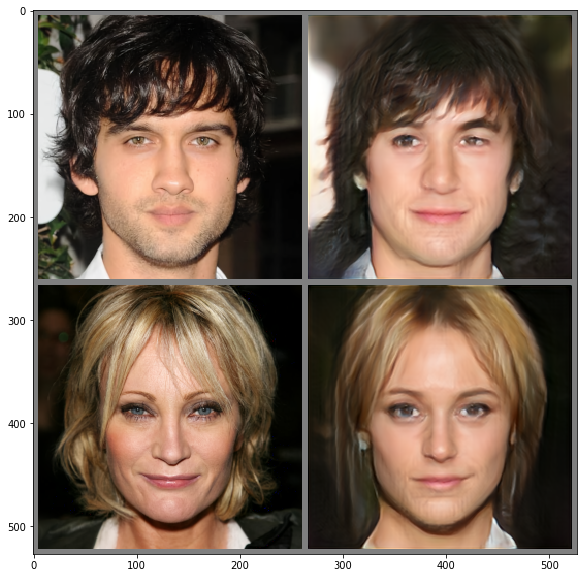

In [6]:
# Reconstruction example

it = get_data_iterator(session, test_data_loader, 2, 256)

reconstruct_running(session,it)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


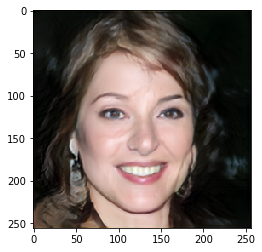

In [8]:
# Random sampling example

imgs = random_faces(session, 12345, 8)
show(imgs[2])

In [8]:
# This code shows how the feature vectors are created. In order to create them yourself, you must e.g. pick 64 or 128 smiling and non-similing images under
# celebAHQ_class/smile
# and
# celebAHQ_class/nosmile
# respectively. The images must be cropped and aligned as in CelebaHQ, hence you can pick them e.g. from the training set.
# We will apply them on test set images.
# By default, we will now create them here but simply load the existing ones in the repo.

saveFeatures = False

if saveFeatures:
    smile_data_loader = data.get_loader(args.data, 'celebAHQ_class/smile')
    nosmile_data_loader = data.get_loader(args.data, 'celebAHQ_class/nosmile')
    smileit = get_data_iterator(session, smile_data_loader, 4, 256)
    nosmileit = get_data_iterator(session, nosmile_data_loader, 4, 256)    
    smile_delta = get_feat_delta(session, smileit, nosmileit)
    
    male_data_loader = data.get_loader(args.data, 'celebAHQ_class/male')
    nomale_data_loader = data.get_loader(args.data, 'celebAHQ_class/nomale')
    maleit = get_data_iterator(session, male_data_loader, 2, 256)
    nomaleit = get_data_iterator(session, nomale_data_loader, 2, 256)    
    male_delta = get_feat_delta(session, maleit, nomaleit)
    
    torch.save(smile_delta, 'attrib/smile_delta2')
    torch.save(male_delta, 'attrib/male_delta2')
else:
    smile_delta = torch.load('attrib/smile_delta')
    male_delta = torch.load('attrib/male_delta')
    glass_delta = torch.load('attrib/glass_delta')
    bald_delta = torch.load('attrib/bald_delta')
    left_delta = torch.load('attrib/left_delta')
    dark_delta = torch.load('attrib/dark_delta')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


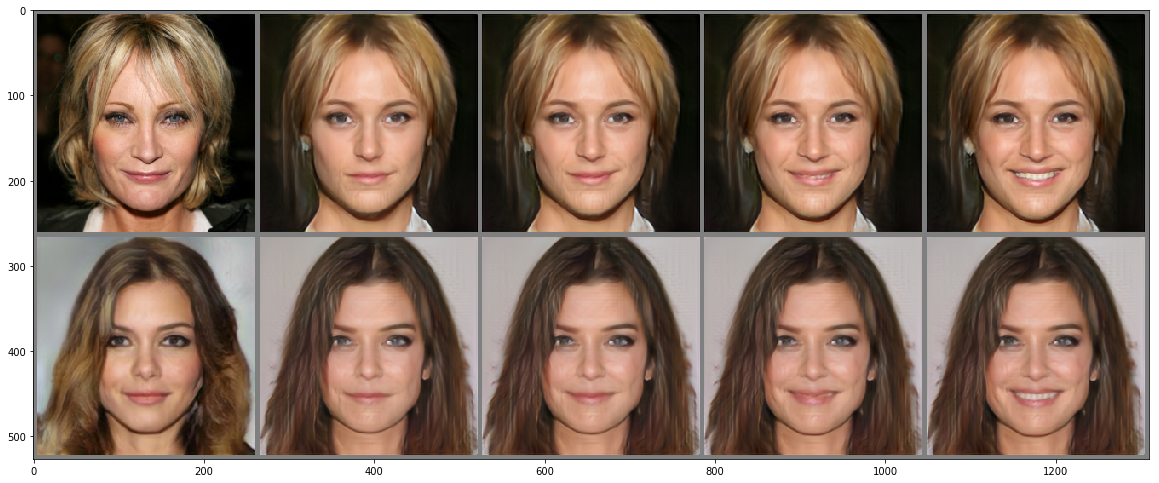

In [10]:
# Attribute manipulation: Smile
# The order of images is:
# 1. real image input, 2. the reconstruction, 3-5. manipulated with the attribute (see alpha)

it = get_data_iterator(session, test_data_loader, 2, 256)

show_feat(session, it, smile_delta, alphas = [0.33, 0.66, 1.0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


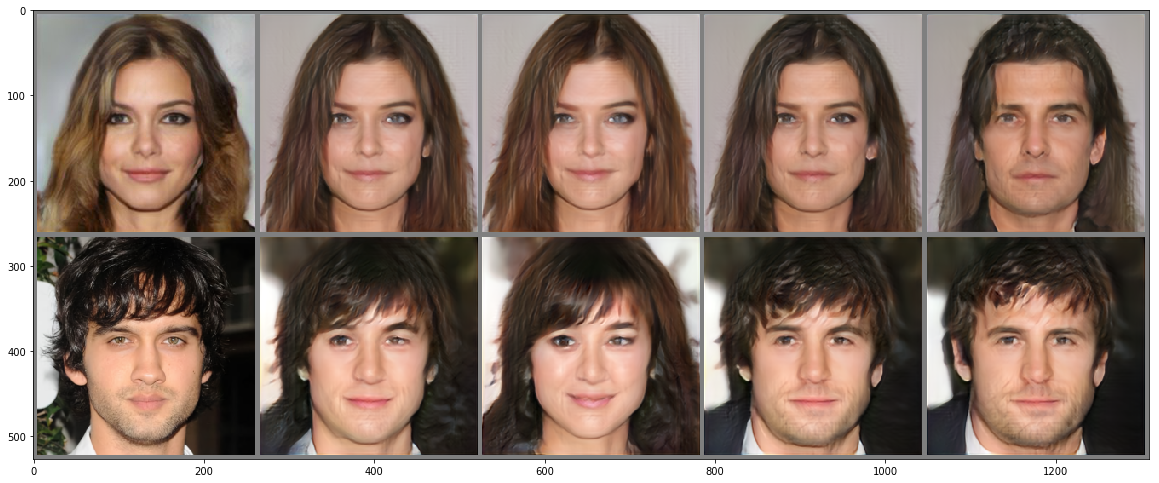

In [20]:
# Attribute manipulation: Male-to-female. Note the use of negative and positive multipliers.

it = get_data_iterator(session, test_data_loader, 2, 256)
show_feat(session, it, male_delta, alphas=[-1, 0.75, 1.5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


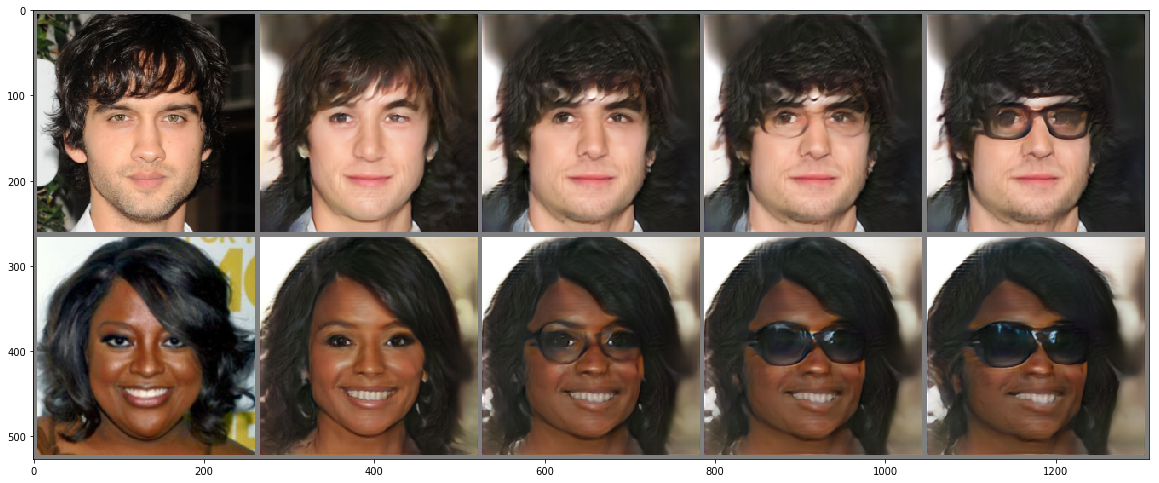

In [25]:
# Attribute manipulation: ADD GLASSES.

it = get_data_iterator(session, test_data_loader, 2, 256)
show_feat(session, it, glass_delta, alphas=[1, 1.25, 1.5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


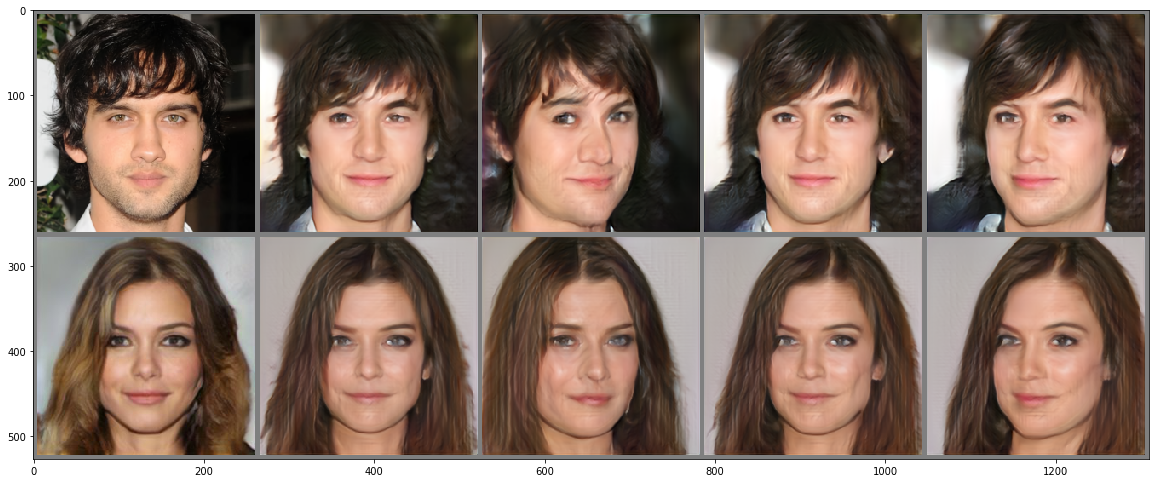

In [26]:
# Attribute manipulation: AZIMUTHAL ROTATION. Note the use of negative and positive multipliers.

it = get_data_iterator(session, test_data_loader, 2, 256)
show_feat(session, it, left_delta, alphas=[-1, 0.5, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


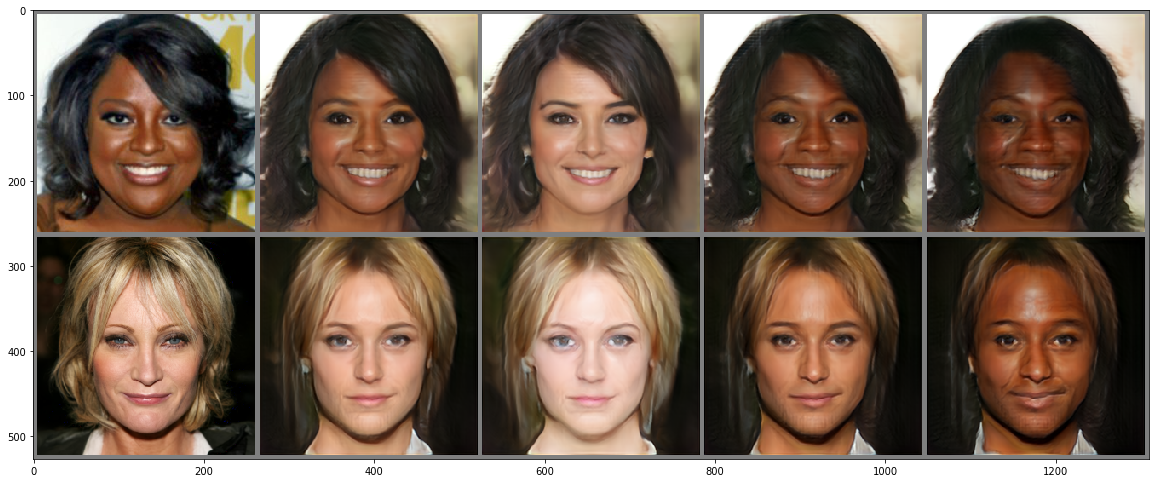

In [28]:
# Attribute manipulation: DARKER / WHITER SKIN. Note the use of negative and positive multipliers.

it = get_data_iterator(session, test_data_loader, 2, 256)
show_feat(session, it, dark_delta, alphas=[-1, 0.75, 1.5])